## Including tower at [ix, iy] = [7, 0] for EE+

In [1]:
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
from skimage.measure import block_reduce # pip install scikit-image
import mpl_scatter_density
import glob, os, time
from torch.utils.data import Dataset, ConcatDataset, DataLoader, sampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import roc_curve, auc
from utils import *
import warnings
import copy
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(0)

Welcome to JupyROOT 6.24/02


In [2]:
figOutDir = './PLOTS/6_Ext_2018_RunEra_Average_Occupancy_EE+/'
os.system('mkdir -p {}'.format(figOutDir))

0

In [3]:
# Import data

files = glob.glob('../DATA/500ev_EE_ECALDQM_*.parquet')
print('Total number of parquet files: {}'.format(len(files)))
#f = [pq.ParquetFile(i) for i in files]

print('\nError reading the file below: ')
f = []
for i in range(len(files)):
    try:
        f.append(pq.ParquetFile(files[i]))
    except:
        print(files[i])
        files[i] = None
files.remove(None)

nEntries = [i.num_row_groups for i in f] 

Total number of parquet files: 240

Error reading the file below: 
../DATA/500ev_EE_ECALDQM_run316766.parquet


In [4]:
class ParquetDataset(Dataset):
    def __init__(self, file):
        self.parquet = pq.ParquetFile(file)
        self.cols = ['PU', 'lumi', 'EEOccupancyTask_EEOT_digi_occupancy_EE_m.list.item.list.item', 'EEOccupancyTask_EEOT_digi_occupancy_EE_p.list.item.list.item']
    def __getitem__(self, index):
        data = dict([])
        for key in self.cols:
            key = key.split('.')[0]
            try:
                data[key] = np.float64(self.parquet.read_row_groups(index, columns=[key]).to_pydict()[key])
            except:
                data[key] = np.float64(self.parquet.read_row_group(index, columns=[key]).to_pydict()[key])
        return data
    def __len__(self):
        return self.parquet.num_row_groups

In [5]:
dataset = {'A': [], 'B': [], 'C': [], 'D': []}

for f in files:
    nRun = int(f.split('./DATA/500ev_EE_ECALDQM_run')[-1].split('.parquet')[0])
    
    if nRun >= 315257 and nRun <= 316995:
        dataset['A'].append(f)
    elif nRun >= 317080 and nRun <= 319077:
        dataset['B'].append(f)
    elif nRun >= 319337 and nRun <= 320065:
        dataset['C'].append(f)
    elif nRun >= 320673 and nRun <= 325172:
        dataset['D'].append(f)
    else:
        print('Run {} does not belong to A-D.\n'.format(nRun))

In [6]:
nDataAll = 0

for era, data in dataset.items():
    nDataAll += len(data)
    print('Run2018{}: {} runs'.format(era, len(data)))
    
print('Total # of runs: {}'.format(nDataAll))

Run2018A: 100 runs
Run2018B: 44 runs
Run2018C: 65 runs
Run2018D: 30 runs
Total # of runs: 239


In [7]:
datasetAll = ConcatDataset([ParquetDataset(f) for f in files])

for era, data in dataset.items():
    dataset[era] = ConcatDataset([ParquetDataset(f) for f in dataset[era]])

In [8]:
# Validation dataset for each run era
batch_size = 3 # time correction

val_sampler_run = {'A': None, 'B': None, 'C': None, 'D': None}
val_loader_run = {'A': None, 'B': None, 'C': None, 'D': None}

val_sampler_run['A'] = sampler.SequentialSampler(range(len(dataset['A'])))
val_loader_run['A'] = DataLoader(dataset=dataset['A'], batch_size=batch_size, num_workers=10, sampler=val_sampler_run['A'], pin_memory=True, drop_last=True)

val_sampler_run['B'] = sampler.SequentialSampler(range(len(dataset['B'])))
val_loader_run['B'] = DataLoader(dataset=dataset['B'], batch_size=batch_size, num_workers=10, sampler=val_sampler_run['B'], pin_memory=True, drop_last=True)

val_sampler_run['C'] = sampler.SequentialSampler(range(len(dataset['C'])))
val_loader_run['C'] = DataLoader(dataset=dataset['C'], batch_size=batch_size, num_workers=10, sampler=val_sampler_run['C'], pin_memory=True, drop_last=True)

val_sampler_run['D'] = sampler.SequentialSampler(range(len(dataset['D'])))
val_loader_run['D'] = DataLoader(dataset=dataset['D'], batch_size=batch_size, num_workers=10, sampler=val_sampler_run['D'], pin_memory=True, drop_last=True)

In [9]:
# GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Functions: Plot Images, Apply PU Correction, Apply Fake Anomalies, Add Padding around the Images

In [10]:
# 2D img plot
def plot_2D(img, title = '', doColorbar=True, doLog=False, label='', xlabel='ix', ylabel='iy', vmax=0, doTick=True, doSave=False, figName='plot'):
    fig, ax = plt.subplots()

    cmap = plt.cm.get_cmap('jet')
    cmap.set_bad(color='black')
    cmap.set_under(color='white')
    
    ax.imshow(np.zeros_like(img), origin='lower', cmap=cmap)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    if doLog:
        im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', norm=LogNorm(), cmap=cmap, vmax=vmax)
    else:
        im = ax.imshow(img, origin='lower', cmap=cmap)
        if vmax != 0:
            im = ax.imshow(img, origin='lower', cmap=cmap, vmax=vmax)

    if doColorbar:
        ax.figure.colorbar(im, ax=ax, fraction=0.045, pad=0.015, label=label)
        
    off = 0.5
    
    if doTick:
        ax.set_xticks(np.arange(0,22,2)-off)
        ax.set_yticks(np.arange(0,22,2)-off)

        ax.set_xticklabels(np.arange(0,22,2))
        ax.set_yticklabels(np.arange(0,22,2))
    
    # HORIZONTAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = 0, 20
        y1, y2 = i, i
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')
    # VERTICAL DASHES
    for i in np.arange(0, 20, 2):
        x1, x2 = i, i
        y1, y2 = 0, 20
        ax.plot([x1-off, x2-off],[y1-off, y2-off], linewidth=1, linestyle='--', color='black')

    
    # labels
    plt.xlabel(xlabel, size=11)
    plt.ylabel(ylabel, size=11)
    plt.title(title, fontsize=13)
    
    if doSave:
        plt.savefig('{}.png'.format(figName))
    
    plt.show()

In [11]:
# Linear regression on Total Occupancy vs. PU

# Apply PU correction to occupancy maps for all LS
# Then multiply by # of towers (20x20) to make the mean occupancy across the pixels 1.

def applyPUcorr(img, PU, fit):
    scale = fit[0]*PU+fit[1]

    # reshape the `scale` tensor if necessary to perform division with `img` tensor, to match the dimensions
    # -> if the img tensor has the size of e.g. [batch_size, 1, 20, 20] whereas PU has the size [batch_size, 1],
    # -> you need to reshape the PU tensor as [batch_size, 1, 1, 1] by adding the extra 2 dimensions
    # -> but if img and PU tensor have the same shape, you don't add any extra dimensions
    scaleShape = list(scale.shape)
    extraDim = [1]*(len(img.shape)-len(PU.shape)) # additional dimensions
    scaleShape += extraDim
    
    scale = scale.reshape(torch.Size(scaleShape))
    
    corrected = img / scale

    return 20*20*corrected

In [12]:
def generateFakeAnomCoord(validIndex, nCoord):
    np.random.seed(0)
    fakeIndex = np.random.randint(0, len(validIndex), size=nCoord) # nCoord == batch_size * (# of batches)
    fakeCoord = [validIndex[i] for i in fakeIndex]
    
    return fakeCoord

def applyFakeAnomaly(img, fakeIndex, anomValue=0):
    if len(fakeIndex) == 2:
        nAnomForLS = int(img.shape[0]) - int(torch.count_nonzero(img[range(img.shape[0]), :, fakeIndex[0], fakeIndex[1]]))
        if nAnomForLS != 0:
            print('Already dead '*nAnomForLS)
        
        img[range(img.shape[0]), :, fakeIndex[0], fakeIndex[1]] = anomValue
    # img has the shape of (N of images, N of layers, rows, cols)
    else:
        fakeIndex = torch.tensor(fakeIndex)
        fakeRows = fakeIndex[:,0]  # extract list of rows
        fakeCols = fakeIndex[:,1]  # extract list of cols

        nAnomForLS = int(img.shape[0]) - int(torch.count_nonzero(img[range(img.shape[0]), :, fakeRows, fakeCols]))
        if nAnomForLS != 0:
            print('Already dead '*nAnomForLS)

        img[range(img.shape[0]), :, fakeRows, fakeCols] = anomValue
        
    return img

In [13]:
def addPadding(img):
    if len(img.shape) == 2:
        pad_top = torch.unsqueeze(img[img.shape[1]-1,:],0)
        img = torch.cat((img, pad_top), 0)
        #plot_2D(img)

        pad_bottom = torch.unsqueeze(img[0,:],0)
        img = torch.cat((pad_bottom, img), 0)
        #plot_2D(img)

        pad_left = torch.unsqueeze(img[:,0], 1)
        img = torch.cat((pad_left, img), 1)
        #plot_2D(img)

        pad_right = torch.unsqueeze(img[:,img.shape[1]-1], 1)
        img = torch.cat((img, pad_right), 1)
        #plot_2D(img.detach().cpu())
        
    elif len(img.shape) == 4:
        pad_top = torch.unsqueeze(img[:,:,img.shape[2]-1,:],2)
        img = torch.cat((img, pad_top), 2)
        #plot_2D(img[10][0].detach().cpu())
        
        pad_bottom = torch.unsqueeze(img[:,:,0,:],2)
        img = torch.cat((pad_bottom, img), 2)
        #plot_2D(img[10][0].detach().cpu())
           
        pad_left = torch.unsqueeze(img[:,:,:,0], 3)
        img = torch.cat((pad_left, img), 3)
        #plot_2D(img[10][0].detach().cpu())
        
        pad_right = torch.unsqueeze(img[:,:,:,img.shape[3]-1], 3)
        img = torch.cat((img, pad_right), 3)
        #plot_2D(img[10][0].detach().cpu())
        
    return img

### Import: Average Occupancy Map, Valid Tower List, PU Fit Parameters

In [14]:
avg_occ_dir = './Avg_Occupancy/'

avg_occupancy_run = {'A': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}, 'B': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}, 'C': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}, 'D': {'p': np.array([[0.]*20]*20), 'm': np.array([[0.]*20]*20)}}
for era in ['A', 'B', 'C', 'D']:
    avg_occupancy_run[era]['p'] = np.loadtxt('{}avg_occupancy_EEp_Run{}.csv'.format(avg_occ_dir, era), delimiter=',')
    avg_occupancy_run[era]['m'] = np.loadtxt('{}avg_occupancy_EEm_Run{}.csv'.format(avg_occ_dir, era), delimiter=',')

In [15]:
avg_occupancy_runAtoB = {'p': np.loadtxt('{}avg_occupancy_EEp_RunAtoB.csv'.format(avg_occ_dir), delimiter=','), 'm': np.loadtxt('{}avg_occupancy_EEm_RunAtoB.csv'.format(avg_occ_dir), delimiter=',')}
avg_occupancy_runAtoC = {'p': np.loadtxt('{}avg_occupancy_EEp_RunAtoC.csv'.format(avg_occ_dir), delimiter=','), 'm': np.loadtxt('{}avg_occupancy_EEm_RunAtoC.csv'.format(avg_occ_dir), delimiter=',')}

In [16]:
valid_tower_dir = './Valid_Tower_List/'
validIndex = {'p': list(np.loadtxt('{}valid_towers_EEp.csv'.format(valid_tower_dir), delimiter=',').astype(int)), 'm': list(np.loadtxt('{}valid_towers_EEm.csv'.format(valid_tower_dir), delimiter=',').astype(int))}

validIndex['p'] = [ idx.tolist() for idx in validIndex['p']]
validIndex['m'] = [ idx.tolist() for idx in validIndex['m']]

validIndex['p'].remove([7,0])

In [17]:
PUdir = './PU_Correction/'

fit_run = {'A': {'p': [], 'm': []}, 'B': {'p': [], 'm': []}, 'C': {'p': [], 'm': []}, 'D': {'p': [], 'm': []}}
for era in ['A', 'B', 'C', 'D']:
    fit_run[era]['p'] = np.loadtxt('{}EEp_PU_Correction_Factor_Run{}.csv'.format(PUdir, era), delimiter=',')
    fit_run[era]['m'] = np.loadtxt('{}EEm_PU_Correction_Factor_Run{}.csv'.format(PUdir, era), delimiter=',')

### ML: Model Class

In [18]:
doPadding = True

In [19]:
class ResBlock(nn.Module):
    '''
    For encoding, define the nominal resnet block
    '''
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

class ResBlockTranspose(nn.Module):
    '''
    For decoding, define the transposed resnet block, aka "de-convolution"
    '''
    def __init__(self, in_channels, out_channels, out_shape=None):
        super(ResBlockTranspose, self).__init__()
        self.upsample = in_channels//out_channels  
        self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=1)
        #self.convT1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=self.upsample, padding=0)
        self.relu = nn.LeakyReLU(inplace=True)
        self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=1)
        #self.convT2 = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, padding=0)

        self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample)
        #self.shortcutT = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=self.upsample, padding=0)
        self.out_shape = out_shape

    def forward(self, x):
        residual = x
        
        if self.out_shape is None:
            out = self.convT1(x)
        else:
            out = self.convT1(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
        out = self.relu(out)
        out = self.convT2(out)

        if self.upsample > 1:
            if self.out_shape is None:
                residual = self.shortcutT(x)
            else:
                residual = self.shortcutT(x, output_size=(x.size()[0], x.size()[1], self.out_shape[0], self.out_shape[1]))
            
        out += residual
        out = self.relu(out)

        return out

In [20]:
if doPadding:
    layer0_kernel = 3
    layer2_shape = 10
    final_shape = 22
else:
    layer0_kernel = 5
    layer2_shape = 8
    final_shape = 20

class ResNetAE(nn.Module):
    '''
    Define the full ResNet autoencoder model
    '''
    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNetAE, self).__init__()

        self.fmaps = fmaps
        self.nblocks = nblocks
        self.in_channels = in_channels
        
        # Initialize encoding layers
        self.econv0 = nn.Sequential(nn.Conv2d(in_channels, fmaps[0], kernel_size=layer0_kernel, stride=1, padding=(0,0)), nn.LeakyReLU())
        self.elayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'enc')
        self.elayer2 = self.block_layers(1, [fmaps[0],fmaps[1]], 'enc')
        self.elayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'enc')
        
        # Initialize decoding layers
        self.fc = nn.Linear(self.fmaps[1], self.fmaps[1]*int(layer2_shape/2)*int(layer2_shape/2))
        self.dlayer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]], 'dec', out_shape=None)
        self.dlayer2 = self.block_layers(1, [fmaps[1],fmaps[0]], 'dec', out_shape=(layer2_shape, layer2_shape))
        self.dlayer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]], 'dec', out_shape=None)
        self.dconv0 = nn.ConvTranspose2d(fmaps[0], in_channels, kernel_size=layer0_kernel, stride=1, padding=(0,0))
        self.dconv0_relu = nn.LeakyReLU(inplace=True)
        
        self.debug = False
        #self.debug = True

    def block_layers(self, nblocks, fmaps, state, out_shape=None):
        '''
        Convenience function: append several resnet blocks in sequence
        '''
        layers = []
        for _ in range(nblocks):
            if state == 'enc':
                layers.append(ResBlock(fmaps[0], fmaps[1]))
            else:
                layers.append(ResBlockTranspose(fmaps[0], fmaps[1], out_shape)) 
        return nn.Sequential(*layers)

    '''
    For VAE:
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).cuda()
        z = mu + std * esp
        return z
    '''

    def forward(self, x):
        
        # Encoding
        if self.debug: print(x.size(), 'input')
        if self.debug: print("Encode")
        x = self.econv0(x)
        if self.debug: print(x.size(), 'econv0')
        x = F.max_pool2d(x, kernel_size=2)
        if self.debug: print(x.size(), 'maxpool')

        x = self.elayer1(x)
        if self.debug: print(x.size(), 'elayer1')
        x = self.elayer2(x)
        if self.debug: print(x.size(), 'elayer2')
        x = self.elayer3(x)
        if self.debug: print(x.size(), 'elayer3')
        
        # Bottleneck comes from GlobalMaxPool
        if self.debug: print("Bottleneck")
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        if self.debug: print(x.size(), 'GlobalMaxPool')
        x = x.view(x.size()[0], -1)
        if self.debug: print(x.size(), 'flatten')
        
        '''
        For VAE:
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        '''
        
        # Expand bottleneck
        # Dimensions follow encoding steps in reverse, as much as possible
        if self.debug: print("Expand bottleneck")
        x = self.fc(x) # expand
        if self.debug: print(x.size(), 'FC-upsample')
        x = x.view(-1, self.fmaps[1], int(layer2_shape/2), int(layer2_shape/2))
        if self.debug: print(x.size(), 'reshape')
        
        # Decoding
        if self.debug: print("Decode")
        x = self.dlayer3(x)
        if self.debug: print(x.size(), 'dlayer3')
        x = self.dlayer2(x)
        if self.debug: print(x.size(), 'dlayer2')
        x = self.dlayer1(x)
        if self.debug: print(x.size(), 'dlayer1')
        
        x = F.interpolate(x, scale_factor=2)
        if self.debug: print(x.size(), "interp")
        x = self.dconv0(x, output_size=(x.size()[0], self.in_channels, final_shape, final_shape)) 
        if self.debug: print(x.size(), 'dconv0')
        x = self.dconv0_relu(x)
            
        return x
        #return x, mu, logvar

### ML Functions: Evalulate during Validation, Calculate FDR

In [21]:
# Spatial Correction

def do_eval(ae, loader, epoch, doPadding=False, isDead=False, isHot=False, fakeIndices=[], avg_occ=[], fit_run=[]):
    loss_ = []

    # Average Occupancy Map for Spatial Correction
    avg_occ = torch.tensor(avg_occ).to(device)
    avg_occ[avg_occ==0] = 1
    
    #fit[EE] = fit_run[runEra][EE]
    
    if doPadding:
        avg_occ = addPadding(avg_occ)
    
    for i, data in enumerate(loader):
        X, PU = data['EEOccupancyTask_EEOT_digi_occupancy_EE_{}'.format(EE)].to(device), data['PU'].to(device)
        
        # PU Correction
        X = applyPUcorr(X, PU, fit_run).float()
        
        # Fake anomaly value
        if isDead or isHot:
            if isDead:
                anomValue = 0
            elif isHot:
                f = 0.2

                hotValue = torch.tensor([25*500*f]*batch_size).to(device)
                hotValue = torch.unsqueeze(hotValue, 1)

                hotValue = applyPUcorr(hotValue, PU, fit_run).float()

                hotValue[hotValue > 8.] = 8. # upperbound cutoff

                anomValue = hotValue
                
            fakeIndex = fakeIndices[i]
        
            # Apply Fake Anomaly
            X = applyFakeAnomaly(X, fakeIndex, anomValue)
        
        # Padding
        if doPadding:
            X = addPadding(X)
        
        # Feed to AE
        Xreco = ae(X)
        
        # Calculate loss: Spatial Correction
        losses = F.mse_loss(Xreco.float()/avg_occ.float(), X.float()/avg_occ.float(), reduction='none')
        
        # Time Correction (with Batch Size 3)
        losses = losses[0]*losses[1]*losses[2]
        losses = torch.unsqueeze(losses, 1)    
            
        # Process loss maps into good and anom losses
        
        # Padding
        if doPadding:
            losses = losses[:,:,1:21,1:21]

        # Get losses of anomalous for anomaly validation and of good towers for good validation
            if isDead or isHot:
                anom_losses = losses[:, :, fakeIndex[0], fakeIndex[1]] # Time Correction: one fake coordinate per batch (batch size of 3)

                loss_.append(anom_losses.tolist())

            else:
                validTowers = torch.tensor(validIndex[EE])
                good_losses = losses[:, :, validTowers[:,0], validTowers[:,1]]
                
                loss_.append(good_losses.tolist())
                
                if EE == 'p':
                    FP = good_losses[good_losses > 0.1069]
                    #FP = good_losses[good_losses > 0.1065]
                else:
                    FP = good_losses[good_losses > 0.1464]

                if FP.size() != torch.Size([0]):
                    if EE == 'p':
                        FP_index = torch.nonzero(good_losses > 0.1069)
                        #FP_index = torch.nonzero(good_losses > 0.1065)
                    else:
                        FP_index = torch.nonzero(good_losses > 0.1464)

                    for i in range(FP_index.shape[0]):
                        FP_indices.append([validTowers[FP_index[i][2], 0].cpu().item(), validTowers[FP_index[i][2], 1].cpu().item()])

               
    # Append losses to list
    if isDead:
        loss_ = np.concatenate(loss_)
        val_dead_loss.append(loss_)
        print('\nEpoch {} > Dead Val loss: {:.4f}'.format(epoch, loss_.mean()))
    elif isHot:
        loss_ = np.concatenate(loss_)
        val_hot_loss.append(loss_)
        print('\nEpoch {} > Hot (f={}) Val loss: {:.4f}'.format(epoch, f, loss_.mean()))
    else:
        loss_ = np.concatenate(loss_)
        val_good_loss.append(loss_)
        print('\nEpoch {} > Good Val loss: {:.4f}'.format(epoch, loss_.mean()))
    
    return loss_

In [22]:
def get_roc(loss_maps, loss_map_anoms):
    anom_map=loss_map_anoms
    norm_map=loss_maps
   
    #anom_thres=np.percentile(anom_map,1)
    if EE == 'p':
        #anom_thres = 0.1069
        anom_thres = 0.1065
    elif EE == 'm':
        anom_thres = 0.1464
    
    print('Anomaly threshold = %.4f'%(anom_thres))
    
    FP = len(norm_map[norm_map > anom_thres])
    TP = len(anom_map[anom_map > anom_thres])
    
    FN = len(anom_map[anom_map < anom_thres])
    TN = len(norm_map[norm_map < anom_thres])
    
    FNR = FN/(FN+TP)
    FPR = FP/(FP+TN)
    
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    
    FDR = FP/(FP+TP)
    
    #print('TPR = {:.4f}'.format(TPR))
    
    print('FDR = {:.4f}'.format(FDR))
    
    return FDR, anom_thres

### Validation for each Run Era: 2018 RunA to RunD

In [23]:
EE = 'p'
modelDir = './MODELS/EE{}/'.format(EE)

# Best epoch from spatial correction validation
if EE == 'p':
    #epoch = 32
    epoch = 30
elif EE == 'm':
    epoch = 33

### RunA

In [24]:
runEra = 'A'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [25]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0000

>> Validation (Time Correction): Dead Tower samples <<<<<<<<
Already dead Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Dead Val loss: 0.7121
Anomaly threshold = 0.1065
FDR = 0.0203

>> Validation (Time Correction): Hot Tower samples <<<<<<<<
Already dead Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Hot (f=0.2) Val loss: 1417582.7455
Anomaly threshold = 0.1065
FDR = 0.0201

FDR
{'dead': [0.02025844662807915], 'hot': [0.0200626541358395]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


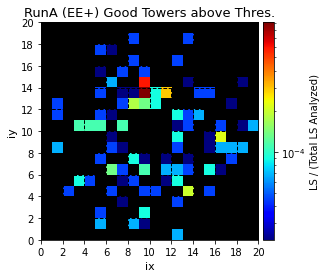

In [26]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

### RunB

In [27]:
runEra = 'B'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [28]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0000

>> Validation (Time Correction): Dead Tower samples <<<<<<<<
Already dead Already dead Already dead 

Epoch 30 > Dead Val loss: 0.6804
Anomaly threshold = 0.1065
FDR = 0.0143

>> Validation (Time Correction): Hot Tower samples <<<<<<<<
Already dead Already dead Already dead 

Epoch 30 > Hot (f=0.2) Val loss: 1315274.2349
Anomaly threshold = 0.1065
FDR = 0.0141

FDR
{'dead': [0.01428408181922066], 'hot': [0.014141871252404119]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


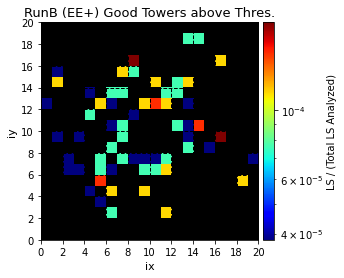

In [29]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

### RunC

In [30]:
runEra = 'C'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [31]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0002

>> Validation (Time Correction): Dead Tower samples <<<<<<<<
Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Dead Val loss: 0.6733
Anomaly threshold = 0.1065
FDR = 0.0890

>> Validation (Time Correction): Hot Tower samples <<<<<<<<
Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Hot (f=0.2) Val loss: 1283799.9521
Anomaly threshold = 0.1065
FDR = 0.0884

FDR
{'dead': [0.0890483224308926], 'hot': [0.08840473447156175]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


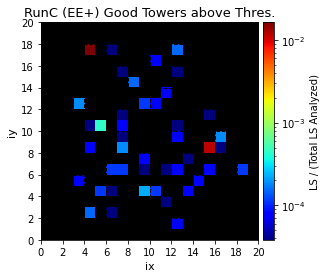

In [32]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

### RunD

In [33]:
runEra = 'D'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [34]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run[runEra][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0001

>> Validation (Time Correction): Dead Tower samples <<<<<<<<

Epoch 30 > Dead Val loss: 0.7913
Anomaly threshold = 0.1065
FDR = 0.0488

>> Validation (Time Correction): Hot Tower samples <<<<<<<<

Epoch 30 > Hot (f=0.2) Val loss: 1769005.5265
Anomaly threshold = 0.1065
FDR = 0.0483

FDR
{'dead': [0.048792041686404546], 'hot': [0.04831144465290807]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


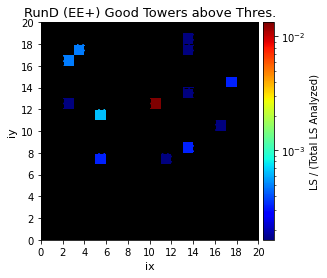

In [35]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

## Spatial Correction Scheme #2: Using Previous Era's Average Occupancy

### RunB

In [36]:
runEra = 'B'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [37]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_run['A'][EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run['A'][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run['A'][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0000

>> Validation (Time Correction): Dead Tower samples <<<<<<<<
Already dead Already dead Already dead 

Epoch 30 > Dead Val loss: 0.7517
Anomaly threshold = 0.1065
FDR = 0.0144

>> Validation (Time Correction): Hot Tower samples <<<<<<<<
Already dead Already dead Already dead 

Epoch 30 > Hot (f=0.2) Val loss: 1598679.3838
Anomaly threshold = 0.1065
FDR = 0.0143

FDR
{'dead': [0.014383561643835616], 'hot': [0.01425339366515837]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


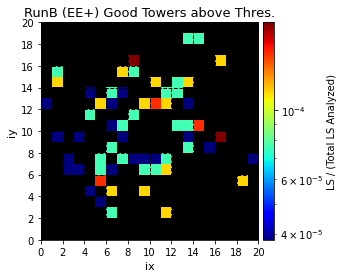

In [38]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

### RunC

In [39]:
runEra = 'C'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [40]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_run['B'][EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run['B'][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run['B'][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0002

>> Validation (Time Correction): Dead Tower samples <<<<<<<<
Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Dead Val loss: 0.7000
Anomaly threshold = 0.1065
FDR = 0.0881

>> Validation (Time Correction): Hot Tower samples <<<<<<<<
Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Hot (f=0.2) Val loss: 1321659.0202
Anomaly threshold = 0.1065
FDR = 0.0871

FDR
{'dead': [0.08809170027594991], 'hot': [0.08706598132801846]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


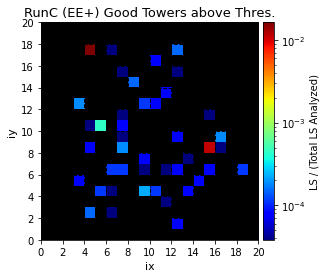

In [41]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

### RunD

In [42]:
runEra = 'D'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [43]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_run['C'][EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run['C'][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_run['C'][EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0001

>> Validation (Time Correction): Dead Tower samples <<<<<<<<

Epoch 30 > Dead Val loss: 0.7935
Anomaly threshold = 0.1065
FDR = 0.0228

>> Validation (Time Correction): Hot Tower samples <<<<<<<<

Epoch 30 > Hot (f=0.2) Val loss: 1656697.8109
Anomaly threshold = 0.1065
FDR = 0.0226

FDR
{'dead': [0.022848808945065628], 'hot': [0.022639691714836225]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


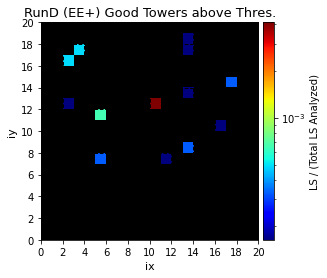

In [44]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

## Spatial Correction Scheme #3: Using Cumulated Previous Eras' Average Occupancy

### RunC

In [45]:
runEra = 'C'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [46]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_runAtoB[EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_runAtoB[EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_runAtoB[EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0002

>> Validation (Time Correction): Dead Tower samples <<<<<<<<
Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Dead Val loss: 0.7327
Anomaly threshold = 0.1065
FDR = 0.0877

>> Validation (Time Correction): Hot Tower samples <<<<<<<<
Already dead Already dead 
Already dead Already dead Already dead 

Epoch 30 > Hot (f=0.2) Val loss: 1490529.4525
Anomaly threshold = 0.1065
FDR = 0.0869

FDR
{'dead': [0.08768399872921741], 'hot': [0.08688352570828961]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


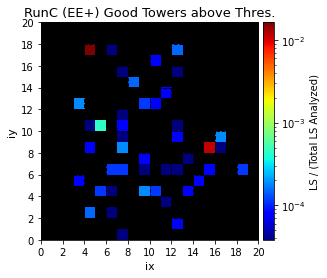

In [47]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)

### RunD

In [48]:
runEra = 'D'
fakeIndices = generateFakeAnomCoord(validIndex[EE], nCoord = batch_size*len(val_loader_run[runEra]))

In [49]:
val_good_loss, val_dead_loss, val_hot_loss = [], [], []

FDRs = {'dead': [], 'hot': []}
all_anom_thres = {'dead': [], 'hot': []}

FP_indices = []

# Run Validation
model = torch.load('{}ae_epoch{}.pth'.format(modelDir, epoch))
model.eval()
print("\n>> Validation (Time Correction): Good samples <<<<<<<<")
good_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=False, avg_occ=avg_occupancy_runAtoC[EE], fit_run=fit_run[runEra][EE])

# Calculate FDR for Dead tower 
print("\n>> Validation (Time Correction): Dead Tower samples <<<<<<<<")
dead_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=True, isHot=False, fakeIndices=fakeIndices, avg_occ=avg_occupancy_runAtoC[EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, dead_losses)
FDRs['dead'].append(FDR)
all_anom_thres['dead'].append(anom_thres)

# Calculate FDR for Hot tower 
print("\n>> Validation (Time Correction): Hot Tower samples <<<<<<<<")
hot_losses = do_eval(model, val_loader_run[runEra], epoch, doPadding=doPadding, isDead=False, isHot=True, fakeIndices=fakeIndices, avg_occ=avg_occupancy_runAtoC[EE], fit_run=fit_run[runEra][EE])

FDR, anom_thres = get_roc(good_losses, hot_losses)
FDRs['hot'].append(FDR)
all_anom_thres['hot'].append(anom_thres)

print('\nFDR')
print(FDRs)
print('\nAnomaly Threshold')
print(all_anom_thres)


>> Validation (Time Correction): Good samples <<<<<<<<

Epoch 30 > Good Val loss: 0.0001

>> Validation (Time Correction): Dead Tower samples <<<<<<<<

Epoch 30 > Dead Val loss: 0.8340
Anomaly threshold = 0.1065
FDR = 0.0273

>> Validation (Time Correction): Hot Tower samples <<<<<<<<

Epoch 30 > Hot (f=0.2) Val loss: 1841330.0485
Anomaly threshold = 0.1065
FDR = 0.0269

FDR
{'dead': [0.02729044834307992], 'hot': [0.02685851318944844]}

Anomaly Threshold
{'dead': [0.1065], 'hot': [0.1065]}


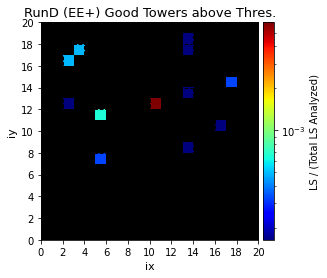

In [50]:
false_pos = np.zeros((20,20))

for index in FP_indices:
    false_pos[index[0]][index[1]] += 1
    
false_pos /= (len(val_loader_run[runEra])*batch_size)
    
plot_2D(false_pos, title='Run{} (EE+) Good Towers above Thres.'.format(runEra), label = 'LS / (Total LS Analyzed)', doLog=True)